# Random Forest

**Objective**: This notebook follows the workflow from the logistic regression notebook to analyse customer reviews using Random forest classifiers to predict certain outcomes based on the text data. The goal is to understand the sentiment or other characteristics of the reviews that could be beneficial for business insights.

**Methodology**: We have employed A Grid search to find the optimal setup for a the Random Forest on both the balanced and unbalanced data. 

**Data**: The analysis uses a dataset of customer reviews that has been preprocessed and vectorized. The dataset was split into training and testing sets, with downsampling applied to address class imbalance, ensuring that our model is robust and less biased. I run the optimisation on each dataset and compare the results.

**Key Findings**:
The random forests improve on the single decicion tree masivley, as expected. They are less prone to overfitting as we use an ensemble of trees. The downsampling helped, and we nearly match th eperformance of the logistic regression. We are focusing on being able to **correctly identify negative reviews** and to infer the most common issues cutsomers have with products. So I will quote the recall of class 0: The model on unbalanced data scored an recall of $0.21$, and the model on balanced data achieved relac of $0.80$. 

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV

%config InlineBackend.figure_format = "retina"
plt.rcParams['figure.figsize'] = (20, 10)


from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, RocCurveDisplay, auc
from sklearn.ensemble import RandomForestClassifier
from source import downsample_binary, my_tokenizer
import joblib


## Random forest on the vectorized reviews
I will first downsample the train data as before, then optimize a decision tree model on the unbalanced data first, then the balanced data with a downsampled majority class and finally compare the results. I am using the vectorisation with 1 and 2-grams

In [88]:
tfidf = TfidfVectorizer(min_df=10,tokenizer = my_tokenizer, max_features=500)
tfidf_2grams = TfidfVectorizer(min_df=10,tokenizer = my_tokenizer, max_features=100, ngram_range=(2,2))
# feature union to combine 1-gram and 2-gram features
combined_features = FeatureUnion([
    ('1gram', tfidf),
    ('2gram', tfidf_2grams)
])

In [89]:
df = pd.read_pickle("../data/reviews_vector_FINAL.pkl")

In [90]:
df.duplicated(subset=df.columns[5:]).sum()

81274

In [91]:
# Splitting the main data
X=df.drop("binary",axis=1)
y=df["binary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [92]:
test_later = X_test

In [93]:
#downsampling X_train
balanced_set = downsample_binary(y_train, X_train)

In [94]:
X_train.columns

Index(['overall', 'reviewText', 'asin', 'length', '1gram__10', '1gram__100',
       '1gram__6s', '1gram__abl', '1gram__absolut', '1gram__access',
       ...
       '2gram__well made', '2gram__work fine', '2gram__work good',
       '2gram__work great', '2gram__work like', '2gram__work perfectli',
       '2gram__work well', '2gram__would buy', '2gram__would definit',
       '2gram__would recommend'],
      dtype='object', length=604)

In [95]:
X_train_unvec = X_train["reviewText"]
X_train = X_train[X_train.columns[4:]]
X_test_unvec = X_test["reviewText"]
X_test = X_test[X_test.columns[4:]]


In [96]:
# balanced class training sets
X_train_bal = balanced_set[balanced_set.columns[5:]]
y_train_bal = balanced_set["binary"]

X_train_bal_unvec = balanced_set["reviewText"]

In [97]:

random_forest_model = RandomForestClassifier(n_estimators=30, random_state=42) 
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=30, random_state=42)

In [12]:
tree_depths = [tree.get_depth() for tree in random_forest_model.estimators_]

max_depth = max(tree_depths)
min_depth = min(tree_depths)
avg_depth = sum(tree_depths) / len(tree_depths)

print(f"Maximum depth in any tree: {max_depth}")
print(f"Minimum depth in any tree: {min_depth}")
print(f"Average depth across all trees: {avg_depth}")

Maximum depth in any tree: 761
Minimum depth in any tree: 640
Average depth across all trees: 699.2


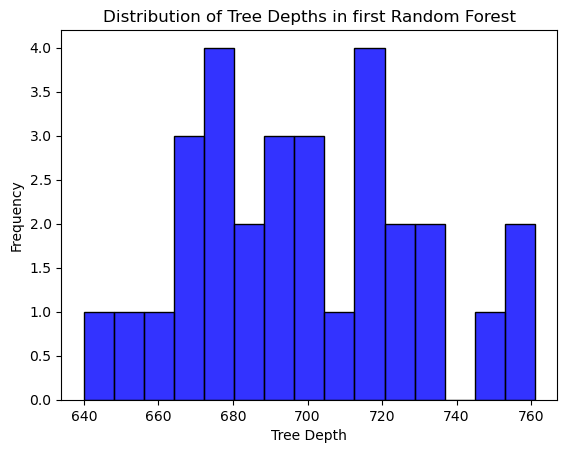

In [13]:
sns.histplot(tree_depths, alpha=0.8, color='blue', bins=15)
plt.xlabel('Tree Depth')
plt.ylabel('Frequency')
plt.title('Distribution of Tree Depths in first Random Forest')
plt.show()

As we can see, the default Random Forest creates 30 *specialized* decision trees, each given a sample of both features and reviews from the overall train set. Each tree is then maximally overfitted, such that every leaf is pure. The range in tree depths is due to the sample fed to each tree being different in size, the resulting overfitted tree has a different length to different one. When we optimise the forest, one of the hyperperameters we tune is "max_depth=k". Setting this will force all $N$ estimators to be of depth $k$. We tune this so ideally most trees are underfitted, although I will compare different "setups". 

In [15]:
y_train_predicted = random_forest_model.predict(X_train)
y_test_predicted = random_forest_model.predict(X_test)
print(classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.76      0.57      0.65     33949
           1       0.88      0.94      0.91    108208

    accuracy                           0.85    142157
   macro avg       0.82      0.76      0.78    142157
weighted avg       0.85      0.85      0.85    142157



### Optimizing a RandomForestClassifier on the balanced data
I will use a grid search to find the best combination of:
- max_depth
- n_estimators

In [ ]:
estimators = [
              ('model', RandomForestClassifier(n_estimators=30, random_state=42))]
pipe = Pipeline(estimators)

params = {
    'model__criterion': ["entropy"],
    'model__n_estimators': [60,80],
    'model__random_state':[42],
    'model__max_depth': [300,500,600]
    # 'model__min_samples_leaf': [3,5]
    # # 'model__min_samples_split':[5,10]  
}

grid_search = GridSearchCV(pipe, param_grid=params, verbose=3, n_jobs=2, cv=3)
fitted_forest = grid_search.fit(X_train, y_train)

In [14]:

estimators_f = [('vectorize', combined_features),
              ('model', RandomForestClassifier(n_estimators=60, max_depth=300,random_state=42))]
pipe_final = Pipeline(estimators_f)
pipe_final.fit(X_train_unvec, y_train)

/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorize',
                 FeatureUnion(transformer_list=[('1gram',
                                                 TfidfVectorizer(max_features=500,
                                                                 min_df=10,
                                                                 tokenizer=<function my_tokenizer at 0x1528968b0>)),
                                                ('2gram',
                                                 TfidfVectorizer(max_features=100,
                                                                 min_df=10,
                                                                 ngram_range=(2,
                                                                              2),
                                                                 tokenizer=<function my_tokenizer at 0x1528968b0>))])),
                ('model',
                 RandomForestClassifier(max_depth=300, n_estimators=60,
                                        random_state=42))])

In [21]:
tree_depths = [tree.get_depth() for tree in pipe_final[-1].estimators_]

max_depth = max(tree_depths)
min_depth = min(tree_depths)
avg_depth = sum(tree_depths) / len(tree_depths)

print(f"Maximum depth in any tree: {max_depth}")
print(f"Minimum depth in any tree: {min_depth}")
print(f"Average depth across all trees: {avg_depth}")

Maximum depth in any tree: 300
Minimum depth in any tree: 300
Average depth across all trees: 300.0


### Optimizing a RandomForestClassifier on the balanced data
I will use a grid search to find the best combination of:
- max_depth
- n_estimators

In [ ]:
estimators_bal = [
              ('model', RandomForestClassifier(n_estimators=30, random_state=42))]
pipe_bal = Pipeline(estimators_bal)

params_bal = {
    'model__criterion': ["entropy"],
    'model__n_estimators': [60,80],
    'model__random_state':[42],
    'model__max_depth': [300,500,600]
    # 'model__min_samples_leaf': [3,5]
    # # 'model__min_samples_split':[5,10]  
}

grid_search_bal = GridSearchCV(pipe_bal, param_grid=params_bal, verbose=3, n_jobs=2, cv=3)
fitted_forest_bal = grid_search_bal.fit(X_train_bal, y_train_bal)

In [ ]:
fitted_forest_bal.best_estimator_

Pipeline(steps=[('normalise', StandardScaler()),
                ('model',
                 RandomForestClassifier(criterion='entropy', max_depth=600,
                                        n_estimators=80, random_state=42))])

In [15]:

estimators_f_bal = [('vectorize', combined_features),
              ('model', RandomForestClassifier(n_estimators=80, max_depth=600,random_state=42))]
pipe_final_bal = Pipeline(estimators_f_bal)
pipe_final_bal.fit(X_train_bal_unvec, y_train_bal)

/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorize',
                 FeatureUnion(transformer_list=[('1gram',
                                                 TfidfVectorizer(max_features=500,
                                                                 min_df=10,
                                                                 tokenizer=<function my_tokenizer at 0x1528968b0>)),
                                                ('2gram',
                                                 TfidfVectorizer(max_features=100,
                                                                 min_df=10,
                                                                 ngram_range=(2,
                                                                              2),
                                                                 tokenizer=<function my_tokenizer at 0x1528968b0>))])),
                ('model',
                 RandomForestClassifier(max_depth=600, n_estimators=80,
                                        random_state=42))])

In [16]:
# serialising the models
joblib.dump(pipe_final, "../model/random-forest-unbal-model.pkl")
joblib.dump(pipe_final_bal, "../model/random-forest-bal-model.pkl")



['../model/random-forest-bal-model.pkl']

In [12]:
# pipe_final_bal=joblib.load("../model/random-forest-bal-model.pkl")
# pipe_final=joblib.load("../model/random-forest-unbal-model.pkl")

In [ ]:
# Evaluation:
1. Visualise beginning of trees
2. Feature importances
3. Confusion matricies and classification reports 
4. ROC
5. SHAP?


In [14]:
# unbal predictions
y_train_pred_f = pipe_final.predict(X_train_unvec)
y_test_pred_f = pipe_final.predict(X_test_unvec) 


In [15]:
# balanced predicitons
y_train_pred_f_bal = pipe_final_bal.predict(X_train_unvec)
y_test_pred_f_bal = pipe_final_bal.predict(X_test_unvec) 


In [16]:
# feature formatting
feature_unbal = [x.replace('1gram__', '').replace('2gram__', '') for x in list(pipe_final[0].get_feature_names_out())]
feature_bal = [x.replace('1gram__', '').replace('2gram__', '') for x in list(pipe_final_bal[0].get_feature_names_out())]

In [17]:
cm = confusion_matrix(y_test, y_test_pred_f)
cm_norm = confusion_matrix(y_test, y_test_pred_f, normalize="true")


In [18]:
cm_bal = confusion_matrix(y_test, y_test_pred_f_bal)
cm_bal_norm = confusion_matrix(y_test, y_test_pred_f_bal, normalize="true")


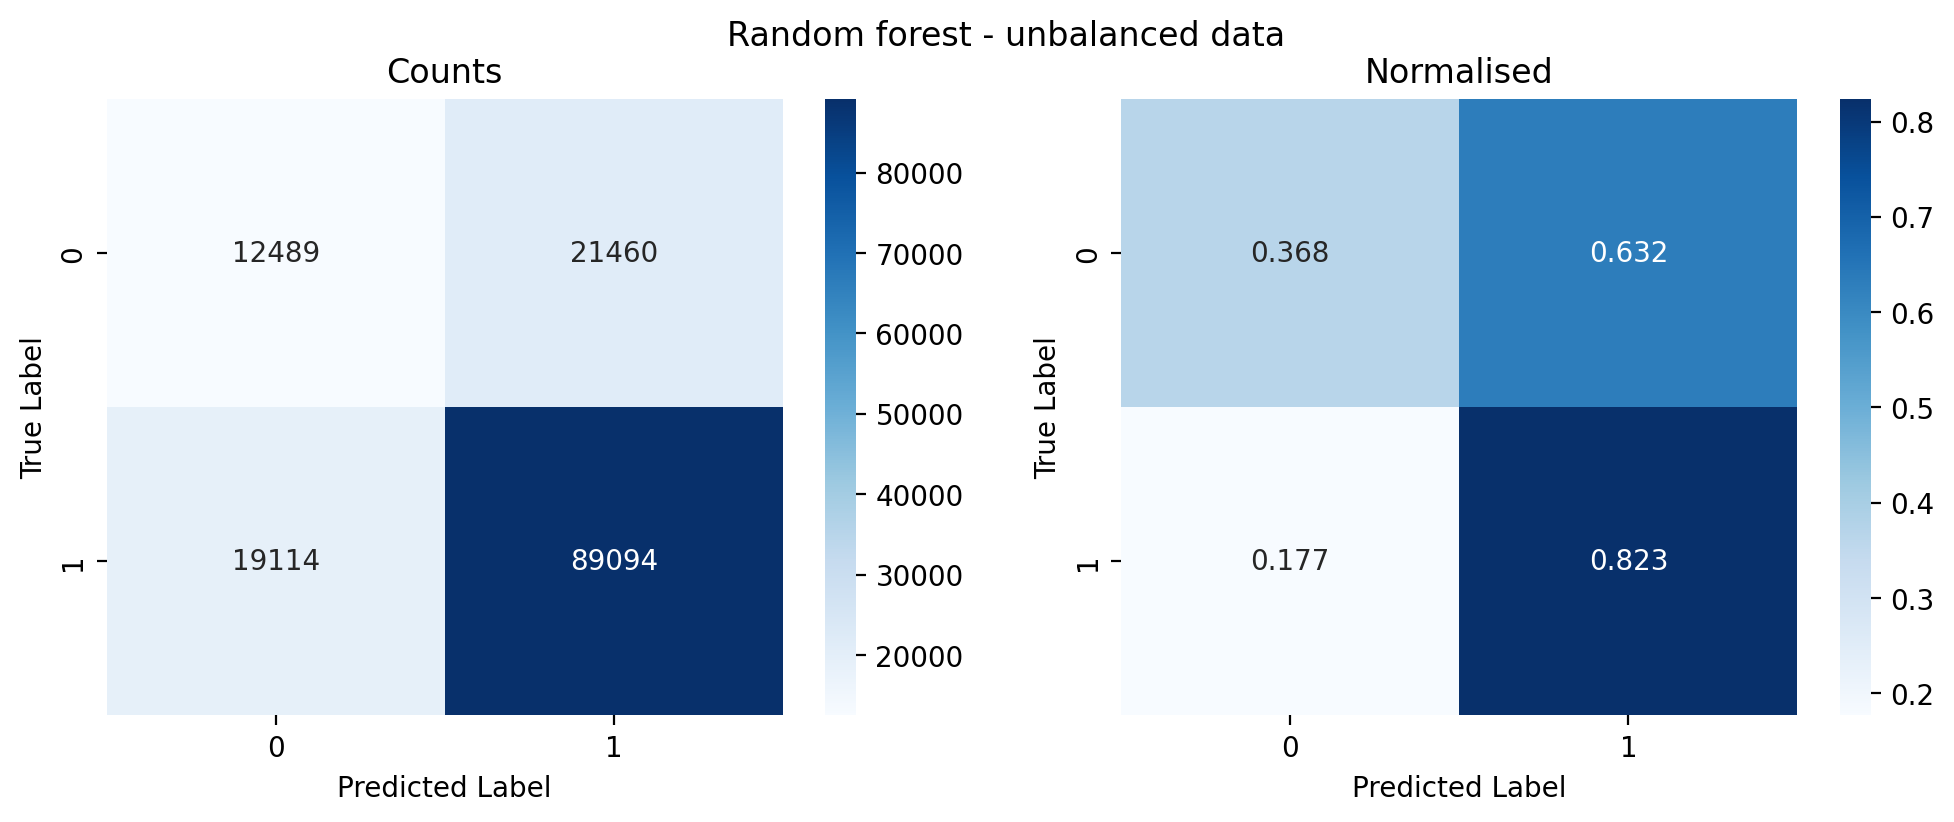

In [19]:
plt.subplots(1,2, figsize=(12, 4))
plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Counts")
plt.subplot(1,2,2)
sns.heatmap(cm_norm, annot=True, fmt=".3f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalised")
plt.suptitle("Random forest - unbalanced data")
plt.show()


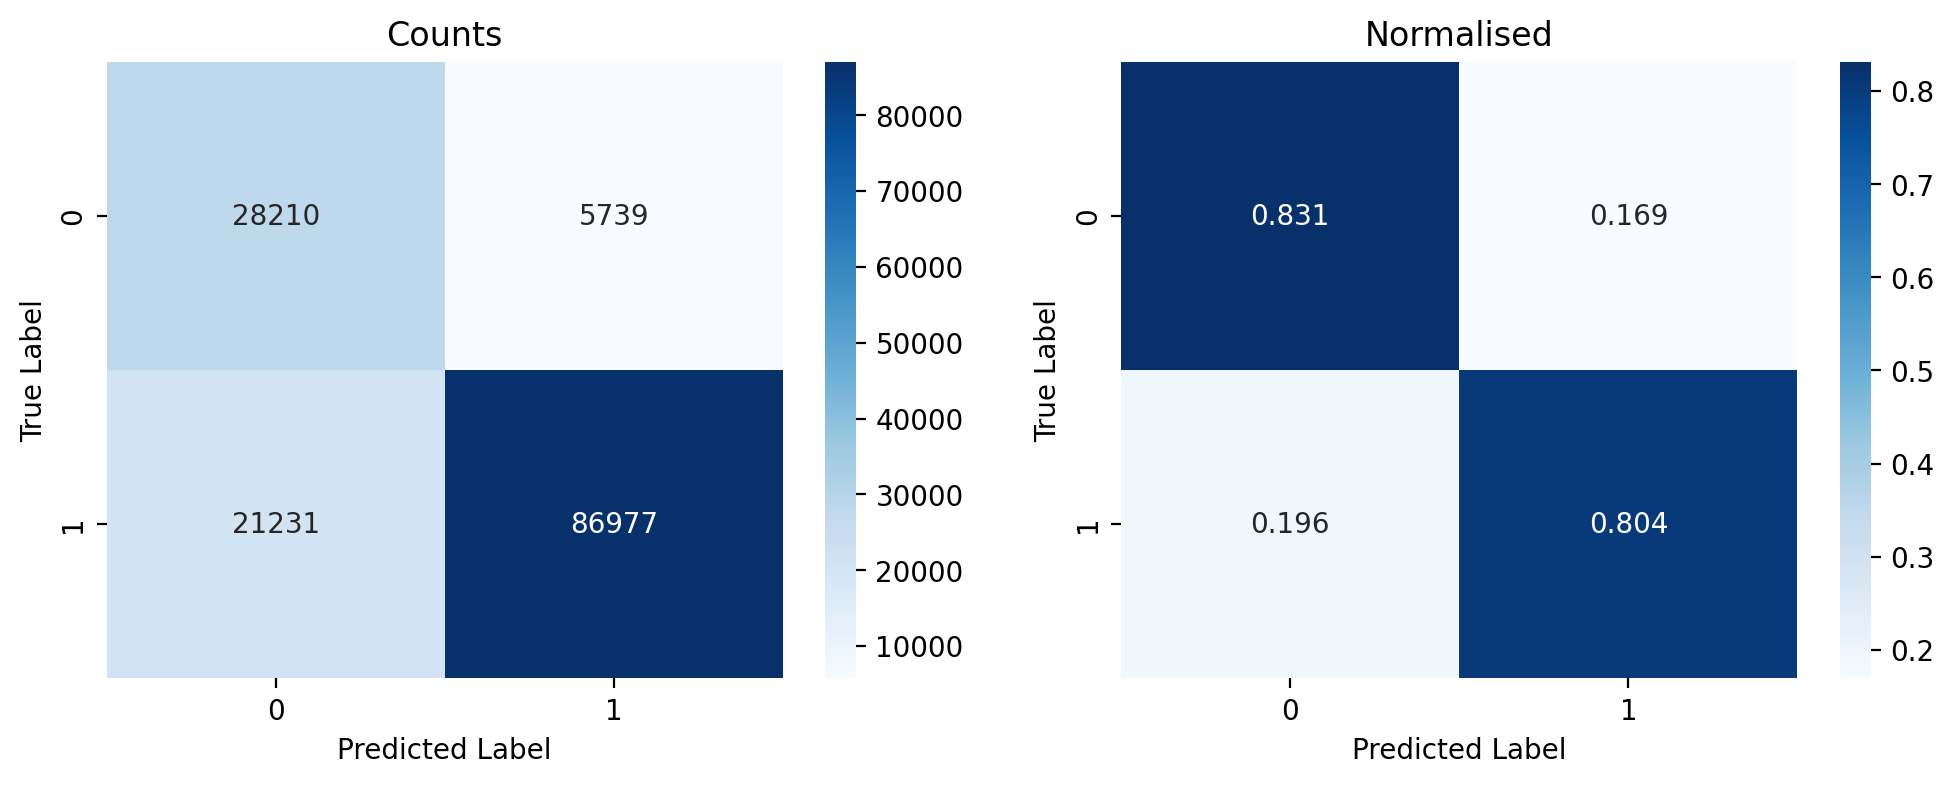

In [20]:
plt.subplots(1,2, figsize=(12, 4))
plt.subplot(1,2,1)
sns.heatmap(cm_bal, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Counts")
plt.subplot(1,2,2)
sns.heatmap(cm_bal_norm, annot=True, fmt=".3f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalised")
plt.title("Normalised")
plt.show()


In [21]:
print(classification_report(y_test, y_test_pred_f))

              precision    recall  f1-score   support

           0       0.40      0.37      0.38     33949
           1       0.81      0.82      0.81    108208

    accuracy                           0.71    142157
   macro avg       0.60      0.60      0.60    142157
weighted avg       0.71      0.71      0.71    142157



In [22]:
print(classification_report(y_test, y_test_pred_f_bal))

              precision    recall  f1-score   support

           0       0.57      0.83      0.68     33949
           1       0.94      0.80      0.87    108208

    accuracy                           0.81    142157
   macro avg       0.75      0.82      0.77    142157
weighted avg       0.85      0.81      0.82    142157



In [23]:
# for ROC later
y_proba_test = pipe_final.predict_proba(X_test_unvec)
y_proba_test_bal = pipe_final_bal.predict_proba(X_test_unvec)

In [24]:
fpr_unbal, tpr_unbal, thresholds_unbal = roc_curve(y_test.values,y_proba_test[:,1])
roc_auc1 = auc(fpr_unbal, tpr_unbal)


In [25]:
fpr_bal, tpr_bal, thresholds_bal = roc_curve(y_test.values,y_proba_test_bal[:,1])
roc_auc2 = auc(fpr_bal, tpr_bal)


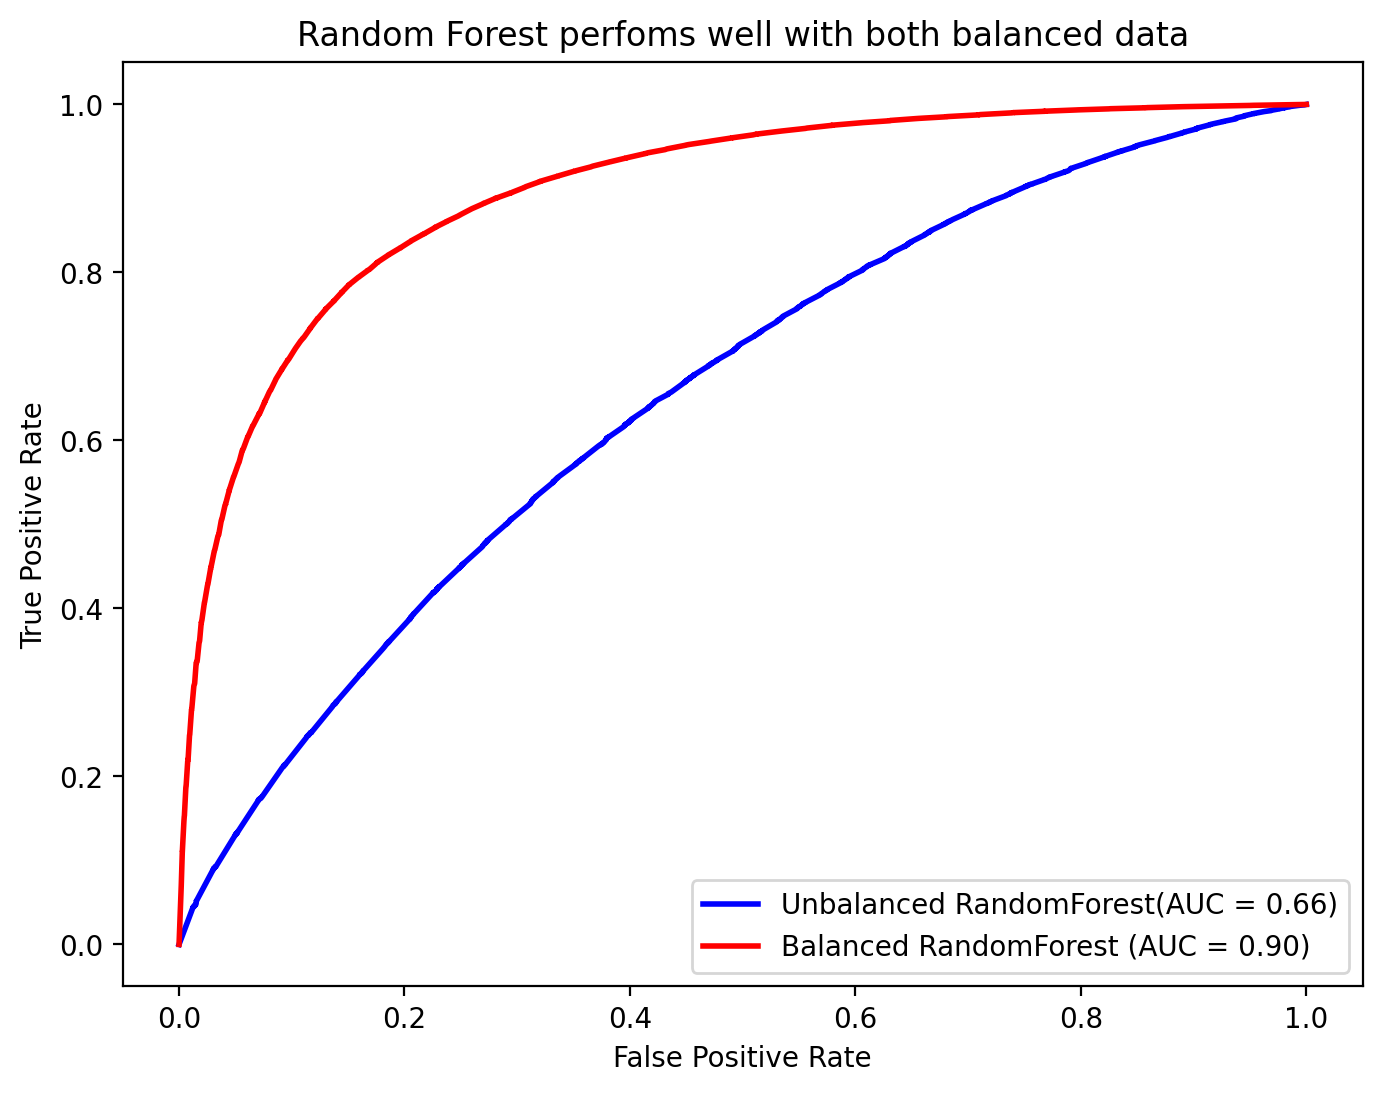

In [26]:
%config InlineBackend.figure_format="retina"
plt.figure(figsize=(8, 6))

# ROC curve for unbalanced model
plt.plot(fpr_unbal, tpr_unbal, color='blue', lw=2, label='Unbalanced RandomForest(AUC = %0.2f)' % roc_auc1)

# ROC curve for balanced model
plt.plot(fpr_bal, tpr_bal, color='red', lw=2, label='Balanced RandomForest (AUC = %0.2f)' % roc_auc2)

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest perfoms well with both balanced data')
plt.legend()


plt.show()

In [27]:
with open('ranfor_roc_data.pkl', 'wb') as f:
    joblib.dump({'fpr_unbal': fpr_unbal, 'tpr_unbal': tpr_unbal, 'roc_auc1': roc_auc1,
                 'fpr_bal': fpr_bal, 'tpr_bal': tpr_bal, 'roc_auc2': roc_auc2}, f)

### Analysis of Random Forest Model Performance

#### Original Unbalanced Dataset:
- **Recall for Negative Reviews (Class 0)**: The recall for negative reviews is 0.37, which indicates that the model correctly identified 37% of the actual negative reviews. This reflects some difficulty in accurately identifying negative reviews, though it's an improvement over the previous model.
- **Precision for Negative Reviews (Class 0)**: The precision stands at 0.40. This means that of all the reviews predicted as negative, 40% were actually negative, showing a modest level of accuracy in these predictions.
- **Overall Accuracy**: The model achieved an overall accuracy of 0.71. However, due to the dataset's imbalance, this number might be skewed towards the model's ability to predict the more dominant positive class.

#### After Downsampling the Majority (Positive) Class:
- **Recall for Negative Reviews (Class 0)**: The recall for negative reviews increased significantly to 0.83, meaning the model now correctly identifies 83% of the negative reviews. This is a substantial improvement, indicating a much-enhanced ability to detect negative reviews.
- **Precision for Negative Reviews (Class 0)**: The precision improved to 0.57, suggesting that 57% of reviews classified as negative were truly negative. This improvement in precision, along with the higher recall, indicates a more balanced performance in classifying negative reviews.
- **Overall Accuracy**: The overall accuracy of the model is 0.81. This decrease in accuracy compared to the unbalanced dataset is primarily due to the model becoming more proficient at identifying negative reviews, which was previously a minority class.

#### Observations:
1. **Significant Improvement in Minority Class Detection**: The most notable enhancement is observed in the recall for the negative class. This improvement suggests that balancing the dataset had a positive impact on the model's ability to correctly classify negative reviews, which is crucial in applications like sentiment analysis.

#### Conclusion:
Balancing the classes by downsampling the majority (positive) class led to a significant improvement in the Random Forest model's capability to detect negative reviews. This improvement is critical in scenarios where identifying the less frequent class is important. The enhanced recall for the negative class, coupled with improved precision, resulted in a more effective and reliable model for sentiment analysis, as reflected in both the improved metrics and the underlying confusion matrices.

## Feature importance for random forest:
The feature importance represents the tokens which lead to the biggest reduciton in entropy and we do not know whether they contribute themselves towards a positive or negative review. Reviews which contain tokens in the top feature importance will be more accurately classified. This is good for overview, however does not help roo much with identifying individual predictions

In [28]:
fi_unbal = pipe_final[1].feature_importances_

feature_imp_unbal = pd.DataFrame(fi_unbal.reshape(1,-1), columns=feature_unbal, index=['Importances']).T
sorted_imp_unbal = feature_imp_unbal.sort_values(by='Importances', ascending=False)

print(sorted_imp_unbal.head(10))

        Importances
happen     0.035298
love       0.028375
review     0.025601
broke      0.016658
differ     0.013399
half       0.012022
phone      0.011021
done       0.010553
pink       0.010503
doesnt     0.010051


In [29]:
fi_bal = pipe_final_bal[1].feature_importances_

feature_imp_bal = pd.DataFrame(fi_bal.reshape(1,-1), columns=feature_bal, index=['Importances']).T
sorted_imp_bal = feature_imp_bal.sort_values(by='Importances', ascending=False)

print(sorted_imp_bal.head(10))

           Importances
great         0.049289
love          0.045174
perfect       0.017704
return        0.016383
good          0.013355
broke         0.012657
nice          0.011709
excel         0.010976
perfectli     0.010585
didnt         0.010280


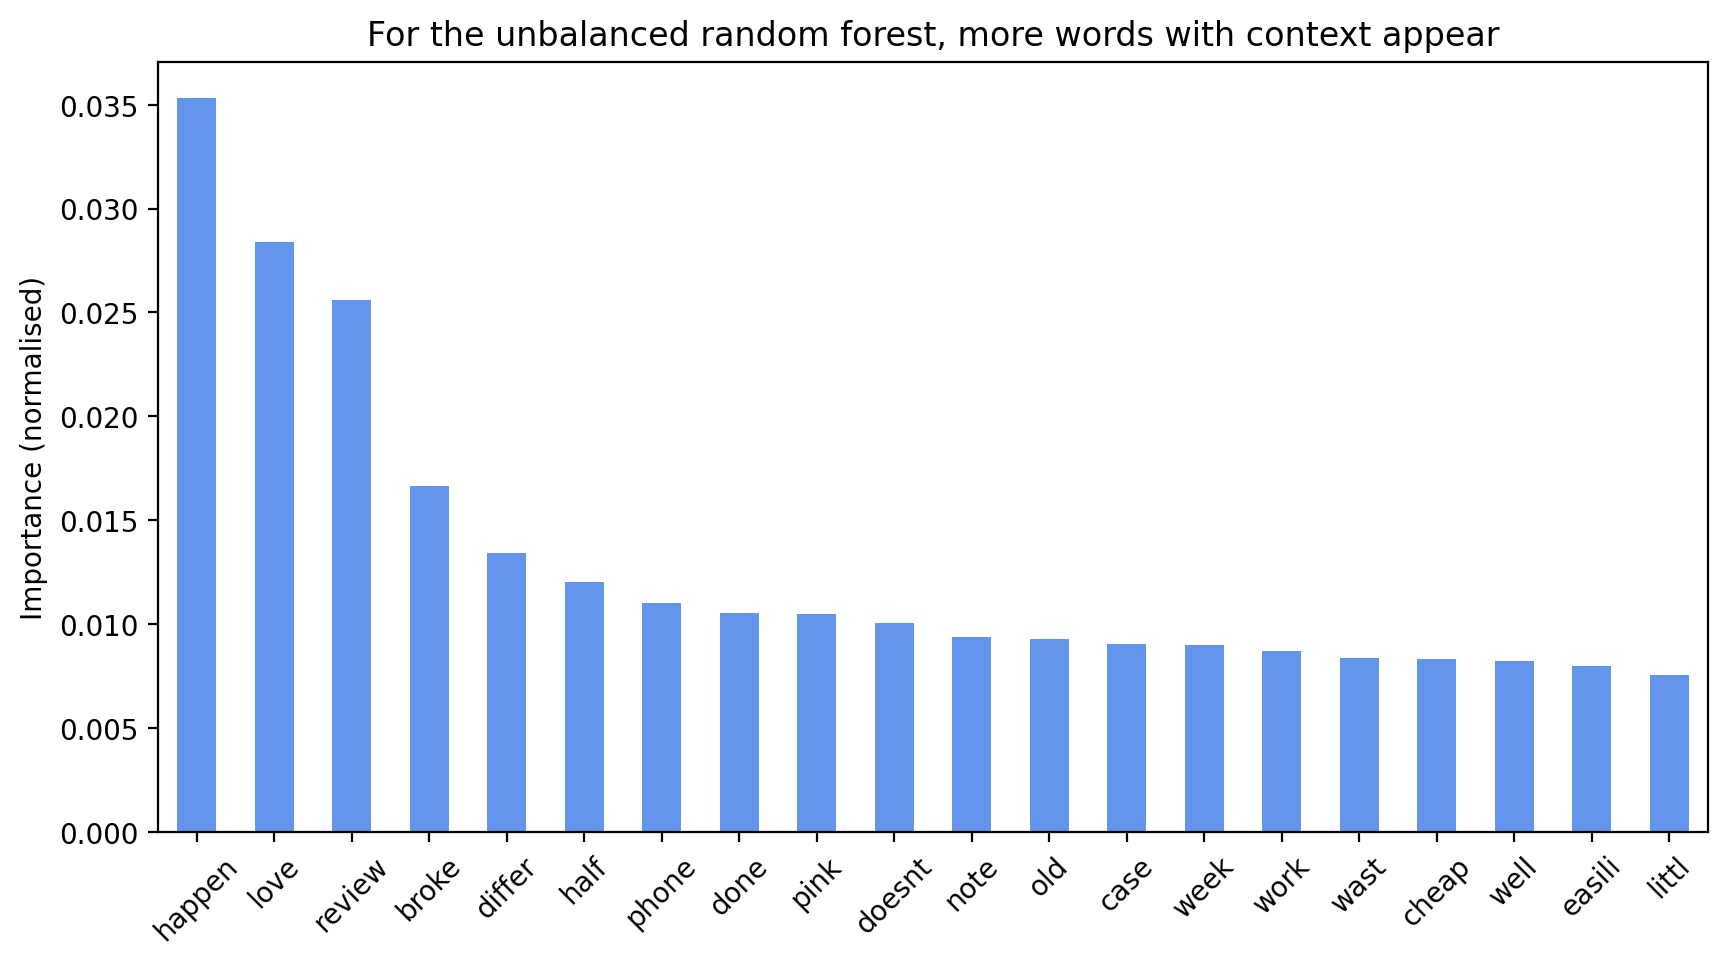

In [30]:
sorted_imp_unbal.head(20).plot(kind="bar", figsize=(10, 5), legend=False, color='cornflowerblue')
plt.title("For the unbalanced random forest, more words with context appear")
plt.ylabel("Importance (normalised)")
plt.xticks(rotation=45)
plt.show()

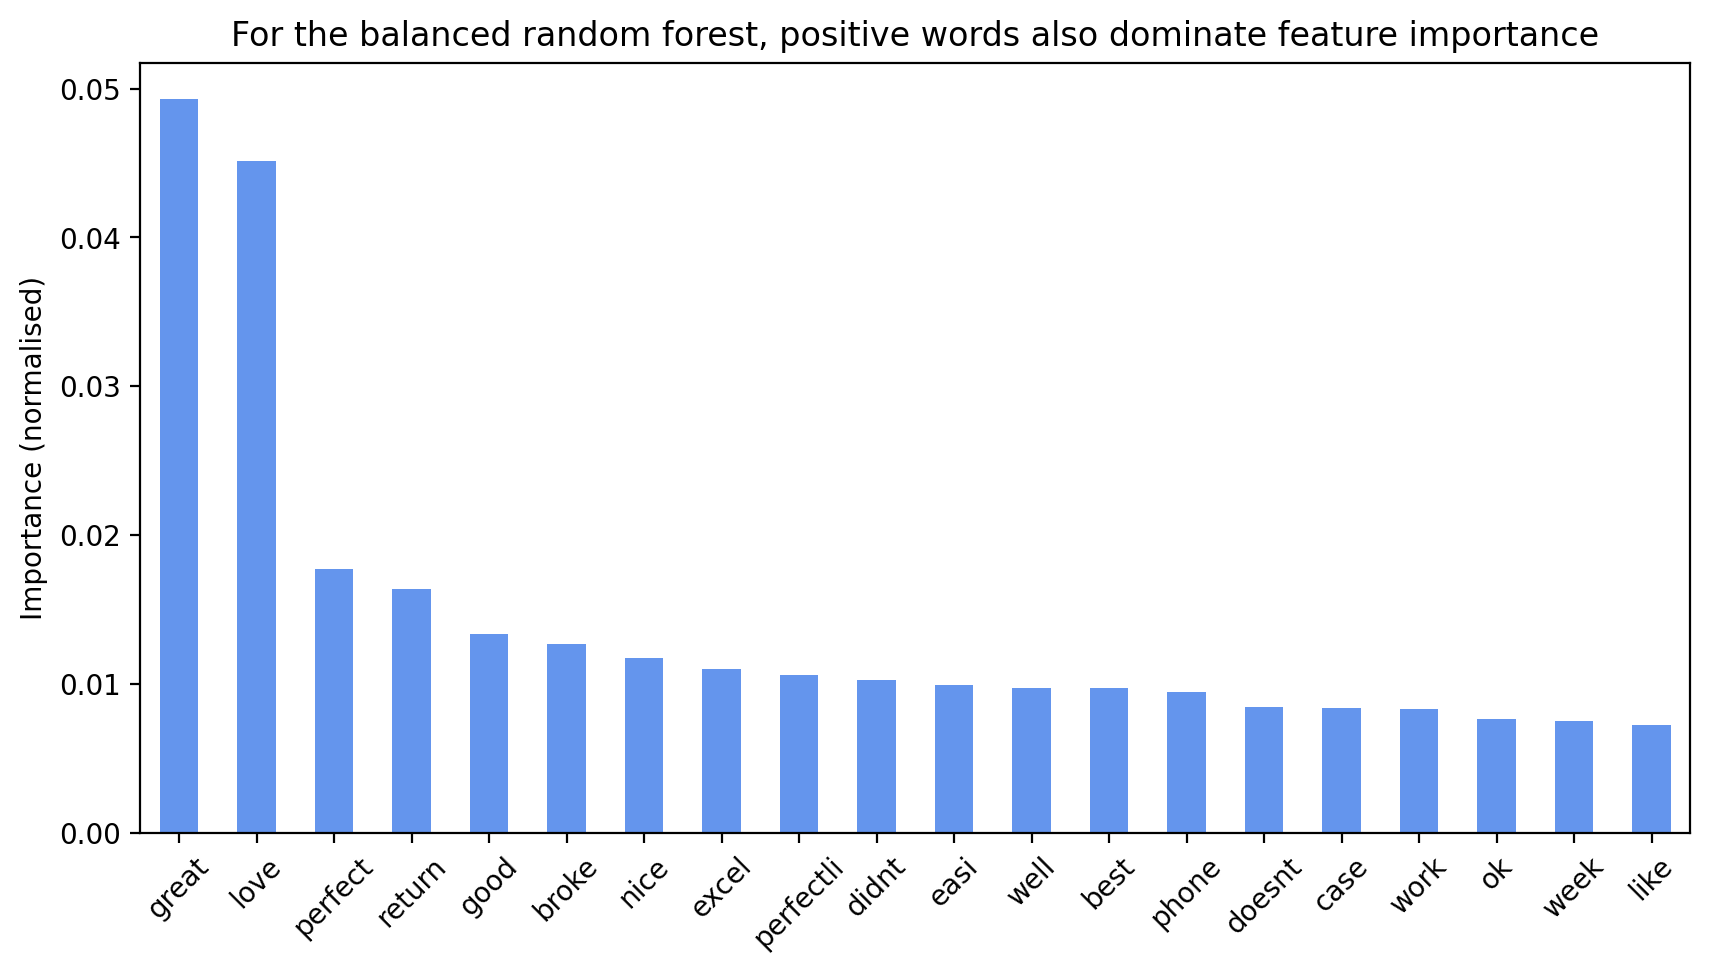

In [31]:
sorted_imp_bal.head(20).plot(kind="bar", figsize=(10, 5), legend=False, color='cornflowerblue')
plt.title("For the balanced random forest, positive words also dominate feature importance")
plt.ylabel("Importance (normalised)")
plt.xticks(rotation=45)
plt.show()

In [32]:
# inspired by Mark Wentink's blog post: https://dsed.uk/posts/string_checking/
set_bal = set(sorted_imp_bal.head(300).index)
set_unbal = set(sorted_imp_unbal.head(300).index)
shared = set_bal.intersection(set_unbal)
diff_a = set_bal.difference(set_unbal)

print(f"In the top 50% of feature importance,\n{len(shared)} are the same between the two models, with {len(diff_a)} differing")

In the top 50% of feature importance,
194 are the same between the two models, with 106 differing


We see that the random forest models actually agree more than the two decision trees did. This is reflected by the unbalanced random forest classifier outperforming the equivalent logistic model.

In [34]:
unbal_out = pd.concat([pd.DataFrame({"actual":y_test,"guess":y_test_pred_f }),test_later], axis=1)
bal_out = pd.DataFrame({"actual":y_test,"guess":y_test_pred_f_bal })

In [35]:
joblib.dump(unbal_out, "../model/rf_unbal_output_df.pkl")
joblib.dump(bal_out, "../model/rf_bal_output_df.pkl")

['../model/rf_bal_output_df.pkl']

**Unbalanced Random Forest Model**:
- Top Feature - 'happen': The most important feature is 'happen' (0.035), indicating its significant role in the model's decision-making process.
- Presence of 'love': 'love' is also a key feature (0.028), suggesting its consistent relevance in sentiment analysis.
- Variety in Feature Importance: The model gives importance to a diverse set of features including 'review', 'broke', and 'differ', which might capture various aspects of sentiment.
- Unique Features: Features like 'phone', 'done', 'pink', and 'doesnt' highlight specific aspects the model focuses on in the unbalanced dataset.

**Balanced Random Forest Model**:
- Top Feature - 'great': 'great' (0.049) emerges as the most significant feature in the balanced model, not present in the top list of the unbalanced model.
- 'love' remains a key feature (0.045), underlining its importance across different data distributions.
- Introduction of New Features: Features such as 'perfect', 'return', 'good', and 'perfectli' gain prominence, indicating a shift in the model's focus due to data balancing.
- While some features like 'broke' retain their importance, others like 'differ', 'phone', and 'done' are replaced by 'nice', 'excel', and 'didnt', reflecting a shift in the model's sensitivity to different tokens.

In [36]:

incorrect_guesses = y_test != y_test_pred_f

incorrect_v = pd.Series(y_test)[incorrect_guesses]
# ig = pd.concat([pd.Series(y_test_pred_f[incorrect_guesses]),pd.Series(incorrect_v), test_later[incorrect_guesses]], axis=1, ignore_index=True)
# ig.rename(columns={0:"guess"}, inplace=True)

In [37]:
incorrect_guesses_unbal = y_test != y_test_pred_f

incorrect_v_unbal = pd.Series(y_test)[incorrect_guesses_unbal]
pred_df_unbal = pd.DataFrame(y_test_pred_f,y_test.index)
pred_df_unbal
ig_unbal = pd.concat([pred_df_unbal[incorrect_guesses_unbal],pd.Series(incorrect_v_unbal), test_later[incorrect_guesses_unbal]], axis=1)
ig_unbal.rename(columns={0:"guess"}, inplace=True)

In [39]:

incorrect_guesses = y_test != y_test_pred_f_bal
incorrect_v = pd.Series(y_test)[incorrect_guesses]
pred_df = pd.DataFrame(y_test_pred_f_bal,y_test.index)
pred_df
ig = pd.concat([pred_df[incorrect_guesses],pd.Series(incorrect_v), test_later[incorrect_guesses]], axis=1)
ig.rename(columns={0:"guess"}, inplace=True)

In [42]:
false_positives = ig[ig["guess"]==1]
false_positives_unbal = ig_unbal[ig_unbal["guess"]==1]

In [80]:
fale_positives_common = list(set(false_positives.index).intersection(set(false_positives_unbal.index)))
fale_positives_common[20:28]

[221222, 172073, 180266, 639019, 393261, 540719, 688177, 213041]

In [77]:
rev_unbal = ig_unbal.loc[688185]
text_u = rev_unbal["reviewText"]
print(f"Actual: {rev_unbal['binary']}, Guess: {rev_unbal[0]}, Overall: {int(rev_unbal['overall'])}")
print(f"Review: {text_u}")

Actual: 0, Guess: 1, Overall: 3
Review: I like matte screen protectors because they provide the best protection against fingerprints and oils from your hands. Having said that these aren't the best solution I've tried, they add the protection but are improperly cut. Though I will add a star for the amount of protectors they give you.


In [81]:
rev = ig.loc[688185]
text = rev["reviewText"]
print(f"Actual: {rev['binary']}, Guess: {rev[0]}, Overall: {int(rev['overall'])}")
print(f"Review: {text[:45]} \n{text[45: 100]} \n{text[101:152]} \n{text[153:]}")

Actual: 0, Guess: 1, Overall: 3
Review: I like matte screen protectors because they p 
rovide the best protection against fingerprints and oil 
 from your hands. Having said that these aren't the 
best solution I've tried, they add the protection but are improperly cut. Though I will add a star for the amount of protectors they give you.


## Summary:

- We optimised the hyperparameters of two Random Forest classifers: one on the original unbalanced data, and one on the balanced downsampled data.
- We saw a significant improvement in both precision and recall when using the balanced logistic model to predict the test set, evidenced in the confusion matricies and the ROC curves. We saw that both models struggle with context, and with long sequences of text. 
- The balanced random forest has performed almost as well as the logistic regression. I chose the logistic regression as the best model due to its ease to  interpret on a review basis.

I tried to do shap but it would not run on my computer, i plan to come back and analyse why this review was wrong. However I imagine the length, and wide variety of vocab would have made it hard to guess.

In [84]:
# import shap
# shap.initjs()

In [86]:
# explainer_unbal = shap.TreeExplainer(pipe_final[1])
# shap_values_unbal = explainer_unbal.shap_values(feature_values)


In [ ]:
# shap.force_plot(explainer_unbal.expected_value[0], shap_values_unbal[0], feature_values)
